In [1]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import mode
from collections import Counter
import seaborn as sns
sc.settings.verbosity = 0 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=70, color_map='viridis')  # low dpi (dots per inch) yields small inline figures
# results_file = './intestine_cells.h5ad'
# results_file_denoised = './intestine_cells_demo.h5ad'

/projects/ps-yeolab5/shsathe/software/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


To begin, we will point to the directory produced by cellranger (or desired published dataset) that contains the following:
1. A barcodes.tsv file
2. A genes.tsv file
3. A matrix.mtx file

At the bare bones, what you need is a counts matrix. This matrix contains the number of read counts for each gene for each cell. While cellranger outputs this as a .mtx file, you can also read files that are excel spreadsheets, text files, etc. See scanpy's documentation for this: https://scanpy.readthedocs.io/en/latest/api/index.html#reading

We are going to use Scanpy's "read_10x_mtx" function because we are reading in a 10X mtx file to analyze.

## Starting from 10X Dataset

In [2]:
adata = sc.read_10x_mtx('/home/jovyan/work/public-data/2_rnaseq/rnaseq_processing_and_analysis/filtered_feature_bc_matrix/',
                       var_names='gene_symbols',                  # use gene symbols for the variable names (variables-axis index)
                        cache=False)

NameError: name 'sc' is not defined

In [3]:
adata

AnnData object with n_obs × n_vars = 11996 × 36601
    var: 'gene_ids', 'feature_types'

**"adata" or AnnData object in scapy is the basis for all data analysis.**

adata is an object that stores the data matrices for observations (individual cells / barcodes) and variables (reference genes)

In this dataset, we have 11996 cells / observations and 36601 genes / variables

In [4]:
adata.obs_names

Index(['AAACCCAAGGCCCAAA-1', 'AAACCCAAGTAATACG-1', 'AAACCCAAGTCACACT-1',
       'AAACCCACAAAGCGTG-1', 'AAACCCACAATCGAAA-1', 'AAACCCACAGATCACT-1',
       'AAACCCACATTGACCA-1', 'AAACCCAGTGAGCCAA-1', 'AAACCCAGTGATAGAT-1',
       'AAACCCAGTGCCTGAC-1',
       ...
       'TTTGTTGCATCACGGC-1', 'TTTGTTGCATCCAACA-1', 'TTTGTTGGTAAGGTCG-1',
       'TTTGTTGGTACAGAGC-1', 'TTTGTTGGTCGCAACC-1', 'TTTGTTGGTTGGATCT-1',
       'TTTGTTGGTTTCTTAC-1', 'TTTGTTGTCCATTTCA-1', 'TTTGTTGTCTACACAG-1',
       'TTTGTTGTCTCATTAC-1'],
      dtype='object', length=11996)

In [5]:
adata.var_names

Index(['MIR1302-2HG', 'FAM138A', 'OR4F5', 'AL627309.1', 'AL627309.3',
       'AL627309.2', 'AL627309.5', 'AL627309.4', 'AP006222.2', 'AL732372.1',
       ...
       'AC133551.1', 'AC136612.1', 'AC136616.1', 'AC136616.3', 'AC136616.2',
       'AC141272.1', 'AC023491.2', 'AC007325.1', 'AC007325.4', 'AC007325.2'],
      dtype='object', length=36601)

### Treat adata.var and adata.obs as DataFrames. Using pandas we can subset and perform operations on the 2 dataframes

In [6]:
adata.var.head()

,gene_ids,feature_types
MIR1302-2HG,ENSG00000243485,Gene Expression
FAM138A,ENSG00000237613,Gene Expression
OR4F5,ENSG00000186092,Gene Expression
AL627309.1,ENSG00000238009,Gene Expression
AL627309.3,ENSG00000239945,Gene Expression


In [7]:
adata.obs.head()

""
AAACCCAAGGCCCAAA-1
AAACCCAAGTAATACG-1
AAACCCAAGTCACACT-1
AAACCCACAAAGCGTG-1
AAACCCACAATCGAAA-1


## Preprocessing

Take a quick look at the genes with the highest fraction of counts in each cell, across all cells

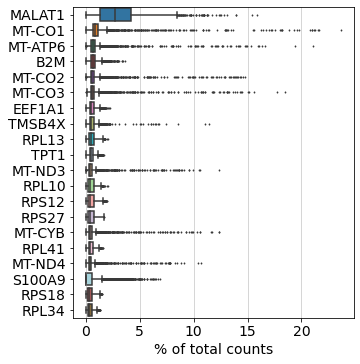

In [8]:
sc.pl.highest_expr_genes(adata, n_top=20)

### Filter data for outlier cells and genes

A. Remove cells with low gene expression

B. Remove rarely expressed genes.

C. Remove genes that have very low expression in cells

In [9]:
sc.pp.filter_cells(adata, min_genes=800)

In [10]:
sc.pp.filter_genes(adata, min_cells=3)

In [11]:
sc.pp.filter_genes(adata, min_counts=5)

### We have filtered out 128 cells and 10,723 genes

In [12]:
adata

AnnData object with n_obs × n_vars = 11868 × 25878
    obs: 'n_genes'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts'

### Let us assemble some information about mitochondrial genes, which are important for quality control.

Citing from “Simple Single Cell” workflows (Lun, McCarthy & Marioni, 2017):

High proportions are indicative of poor-quality cells (Islam et al. 2014; Ilicic et al. 2016), possibly because of loss of cytoplasmic RNA from perforated cells. The reasoning is that mitochondria are larger than individual transcript molecules and less likely to escape through tears in the cell membrane.

Mitochondrial genes are prefixed with "MT-". Let's compute the fraction of mitochondrial gene expression in each cell. We will exclude any cell with a high amount of mitochondrial expression.

In [13]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

A violin plot of the computed quality measures.

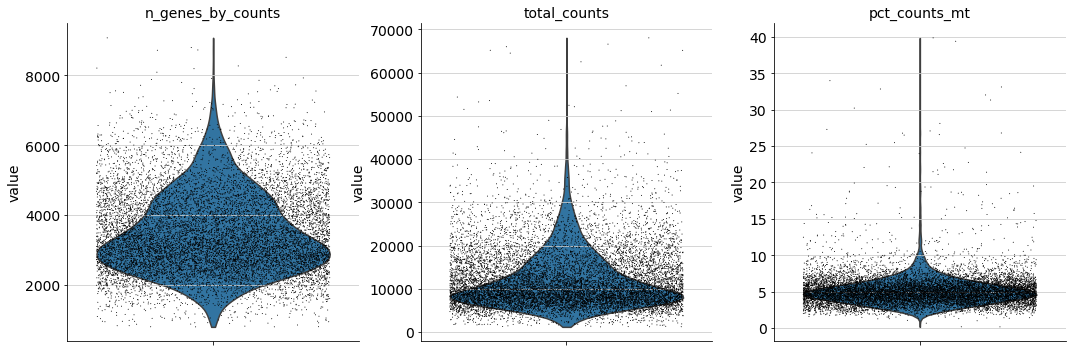

In [14]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

### Check if high mitochondrial content is corelated with dead cells. Dead cells will return a low read depth.

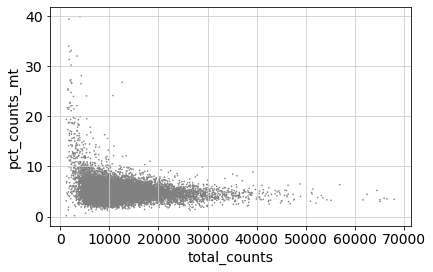

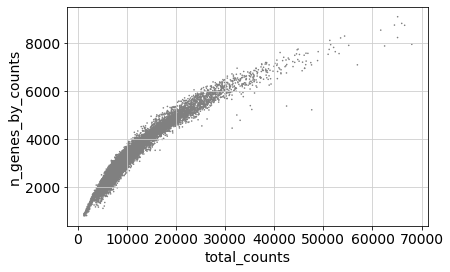

In [15]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

Mitochondrial content is generally high among cells with low read depth. 

In [16]:
conditions = [
    (adata.obs['n_genes_by_counts'] < 500),
    (adata.obs['pct_counts_mt'] > 15),
    (adata.obs['pct_counts_mt'] <= 15) & (adata.obs['n_genes_by_counts'] >= 500)]

values = ['Low_nFeature', 'High_MT', 'Pass']
adata.obs['QC'] = np.select(conditions, values)
adata.obs['QC'] = adata.obs['QC'].astype('category')
adata.obs[['n_genes_by_counts','pct_counts_mt','QC']].head(10)

,n_genes_by_counts,pct_counts_mt,QC
AAACCCAAGGCCCAAA-1,4250,4.856472,Pass
AAACCCAAGTAATACG-1,3783,4.182156,Pass
AAACCCAAGTCACACT-1,4147,5.816601,Pass
AAACCCACAAAGCGTG-1,2528,3.800104,Pass
AAACCCACAATCGAAA-1,3492,5.699887,Pass
AAACCCACAGATCACT-1,2675,4.974540,Pass
AAACCCACATTGACCA-1,3906,4.171661,Pass
AAACCCAGTGAGCCAA-1,5996,3.885146,Pass
AAACCCAGTGATAGAT-1,2098,6.113537,Pass
AAACCCAGTGCCTGAC-1,3050,3.751006,Pass


In [17]:
adata.obs['QC'].value_counts()

Pass       11787
High_MT       81
Name: QC, dtype: int64

### Filter for cells that pass QC

In [18]:
adata = adata[adata.obs['QC'] == 'Pass', :]
# Removed 81 cells for failing QC
adata

View of AnnData object with n_obs × n_vars = 11787 × 25878
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'QC'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'

### Normalize the data matrix to 10,000 reads per cell (library-size correction), so that counts become comparable among cells. Then log normalize the counts.

In [19]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)

/home/shsathe/.local/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:524: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[key_n_counts] = counts_per_cell


Now we filter the data for the most variable genes

In [20]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

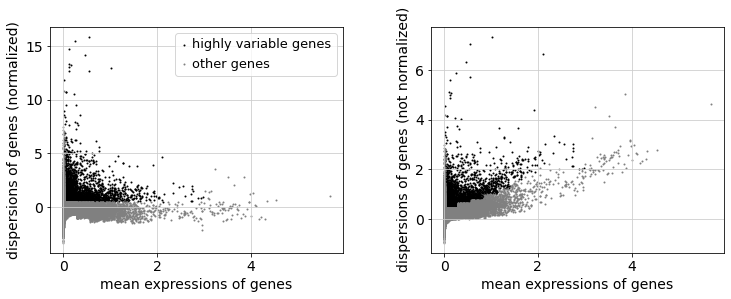

In [21]:
sc.pl.highly_variable_genes(adata)

In [22]:
adata.var.head()

,gene_ids,feature_types,n_cells,n_counts,mt,n_cells_by_counts,mean_counts,pct_dropout_by_counts,total_counts,highly_variable,means,dispersions,dispersions_norm
AL627309.1,ENSG00000238009,Gene Expression,111,115.0,False,111,0.009690,99.064712,115.0,False,0.008623,0.685331,1.170633
AL627309.3,ENSG00000239945,Gene Expression,7,7.0,False,7,0.000590,99.941018,7.0,False,0.000518,0.026210,-0.641909
AL627309.5,ENSG00000241860,Gene Expression,654,706.0,False,654,0.059488,94.489383,706.0,False,0.041851,-0.007306,-0.734075
AL627309.4,ENSG00000241599,Gene Expression,13,14.0,False,13,0.001180,99.890462,14.0,False,0.000862,-0.054744,-0.864527
AL669831.2,ENSG00000229905,Gene Expression,8,8.0,False,8,0.000674,99.932592,8.0,False,0.000387,-0.266854,-1.447815


Now do the filtering

In [23]:
adata = adata[:, adata.var['highly_variable']]

In [24]:
adata

View of AnnData object with n_obs × n_vars = 11787 × 3505
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'QC', 'n_counts'
    var: 'gene_ids', 'feature_types', 'n_cells', 'n_counts', 'mt', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

We used to have 25k genes and now we are at 3505

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

Scale each gene to unit variance. Clip values exceeding standard deviation 10.

In [ ]:
sc.pp.scale(adata, max_value=10)

## PCA

Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises (noise reduction) the data.

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')

We can make a scatter plot in the PCA coordinates, but we will not use that later on.

In [ ]:
sc.pl.pca(adata)

In [ ]:
adata.var_names

If we want we can add additional genes to look at

In [ ]:
sc.pl.pca(adata, color="HES4")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function sc.tl.louvain() or tSNE sc.tl.tsne(). Usually, a rough estimate of the number of PCs does fine.

In [ ]:
sc.pl.pca_variance_ratio(adata, log=True)

What we are looking for is how many principle components to use in the future computation of our neighborhood graphs. We can see from the graph above that we capture almost all of the varaiance in the first 10 principle components so that is the number we will use going forward.

Now lets save the results

In [ ]:
adata.write('scanpy_results.h5ad')

In [ ]:
adata

## Computing the neighborhood graph

Using the PCA representation of the data matrix we can now compute the neighborhood graph. This means that we are estimating how connected all of the data points are - the connectivity of the manifold.

Scanpy pp.neighbors relies heavily on UMAP and the n_neighbors integer is the size of local neighborhood (in terms of number of neighboring data points) used for manifold approximation. Larger values result in more global views of the manifold, while smaller values result in more local data being preserved.

In [ ]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

## Embedding the neighborhood graph

An embedding is a representation of a topological object, manifold, graph, field, etc. in a certain space in such a way that its connectivity or algebraic properties are preserved. Scanpy offers several flavors with different advantages and disadvantages to each: PCA, tSNE, UMAP, Force-directed, and Diffusion Maps. 

First we will try to UMAP (McInnes et al., 2018) https://arxiv.org/abs/1802.03426

In [34]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=10)

ValueError: Did not find 'neighbors/connectivities'. Run `sc.pp.neighbors` first.

If we knew something about these cells before sequencing we could add annotation and color the cells by that annotation. We can change some of the plotting parameters like this:

In [ ]:
sc.tl.umap(adata)

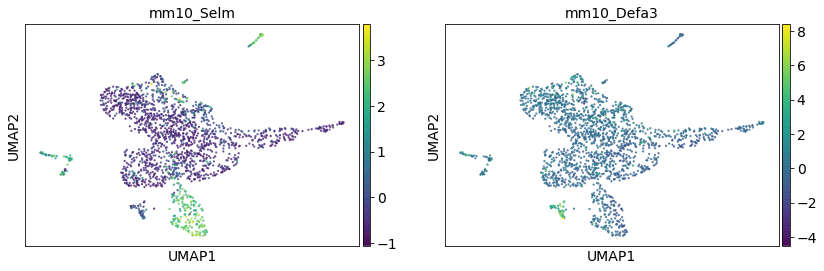

In [31]:
sc.pl.umap(adata, color=['CST3', 'NKG7', 'PPBP'])

If you also wanted to try the Force-directed graph drawing [Islam11] [Jacomy14] [Chippada18]. An alternative to tSNE that often preserves the topology of the data better. This requires to run neighbors(), first.

In [32]:
adata.var.sort_values('std', ascending=False).head()

Alternatively, if you want to produce a tSNE you can do the following:

In [34]:
sc.tl.tsne(adata, n_pcs = 10, early_exaggeration = 5)

There are several settings when computing tSNE but two are perplexity: "The perplexity is related to the number of nearest neighbors that is used in other manifold learning algorithms. Larger datasets usually require a larger perplexity. Consider selecting a value between 5 and 50. The choice is not extremely critical since t-SNE is quite insensitive to this parameter." 
and early_exaggeration: "Controls how tight natural clusters in the original space are in the embedded space and how much space will be between them. For larger values, the space between natural clusters will be larger in the embedded space. Again, the choice of this parameter is not very critical. If the cost function increases during initial optimization, the early exaggeration factor or the learning rate might be too high."

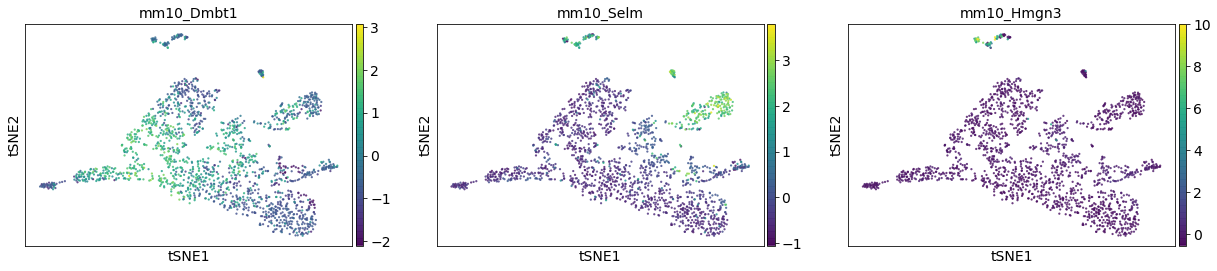

In [35]:
sc.pl.tsne(adata, color=['NKG7','CD74','CTSS'], legend_loc='on data', legend_fontsize=7, alpha=0.8, size=20)

## Clustering the neighborhood graph

In [36]:
sc.tl.leiden(adata)

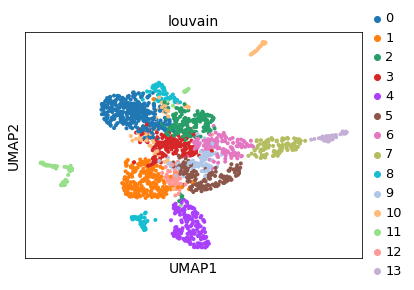

In [37]:
sc.pl.umap(adata, color=['leiden', 'CD74','CTSS'])

When looking at both the UMAP and tSNE it looks to me like 13 clusters is a little ambitious. So if we want to recluster with a lower resolution we will get less clusters (1 is the default)

## Finding Marker Genes

The easiest way to do this is using a t-test to find differentially expressed genes between one cluster and all of the other clusters.

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:224: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


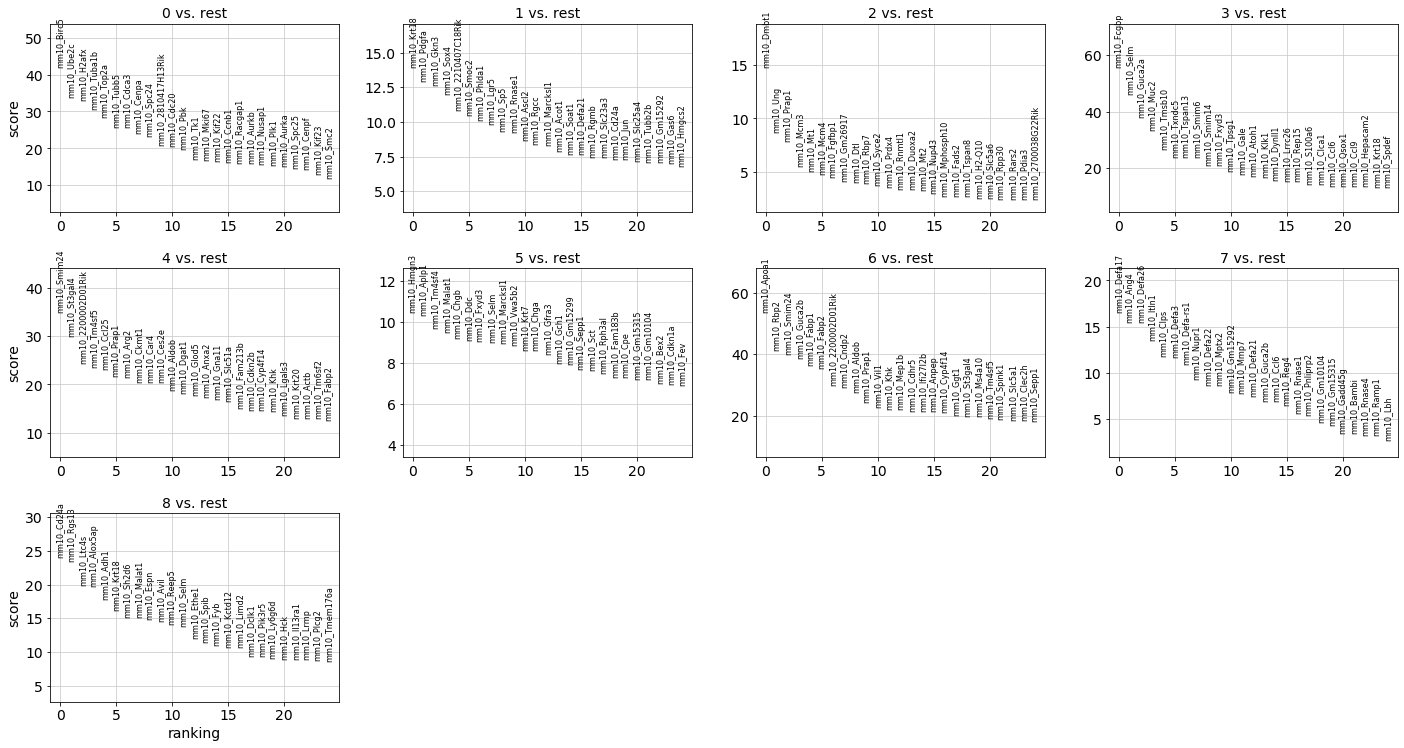

In [43]:
sc.tl.rank_genes_groups(adata, 'leiden', method='t-test')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

Check out a detailed explanation of the wilcoxin rank sum test [here](https://www.stat.auckland.ac.nz/~wild/ChanceEnc/Ch10.wilcoxon.pdf). 

The t-test assumes your data is normally distributed. This is often not the case. For a non-parametric test we can then use the Mann-Whitney test.

/opt/conda/lib/python3.6/site-packages/scanpy/tools/_rank_genes_groups.py:389: RuntimeWarning: invalid value encountered in log2
  rankings_gene_logfoldchanges.append(np.log2(foldchanges[global_indices]))


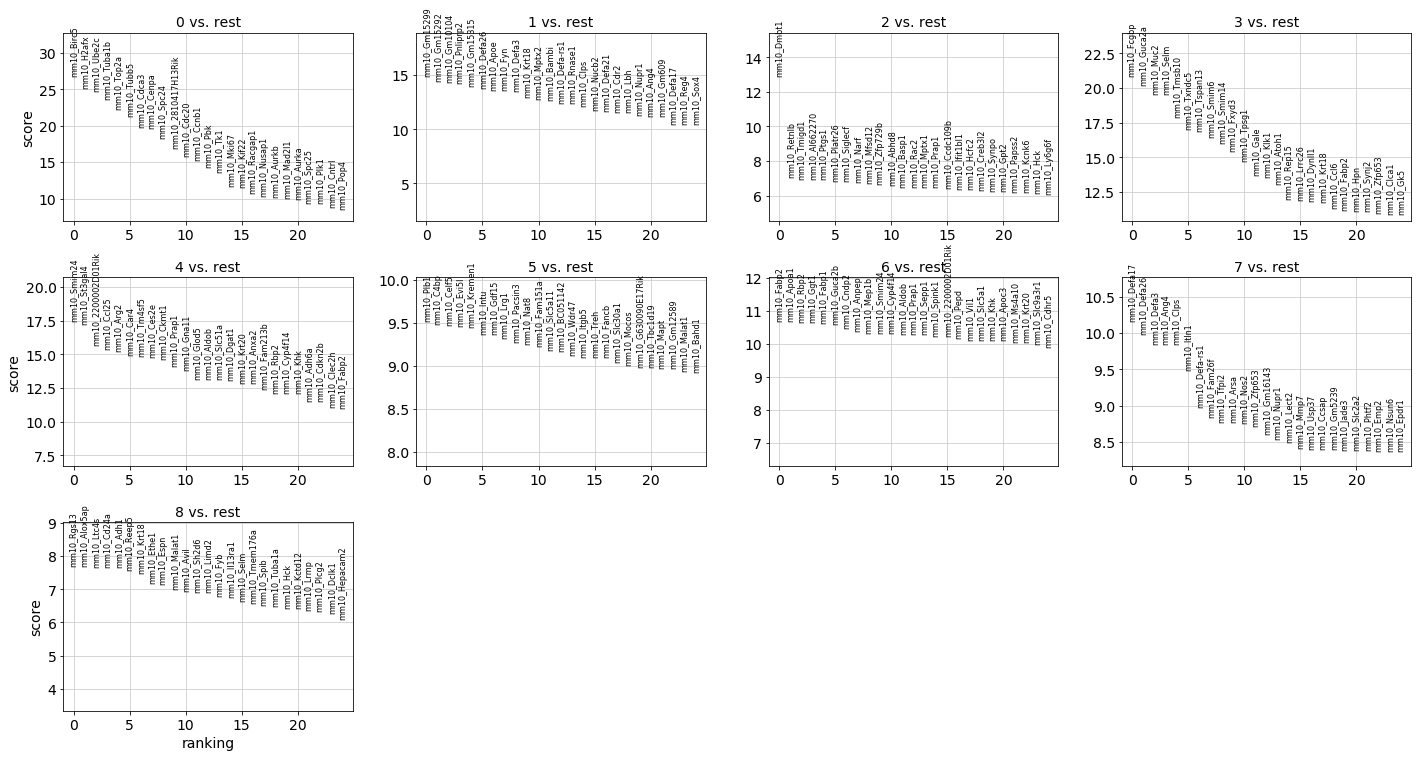

In [44]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

As an alternative, let us rank genes using logistic regression. For instance, this has been suggested by Natranos et al. (2018). The essential difference is that here, we use a multi-variate appraoch whereas conventional differential tests are uni-variate. Clark et al. (2014) has more details.

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


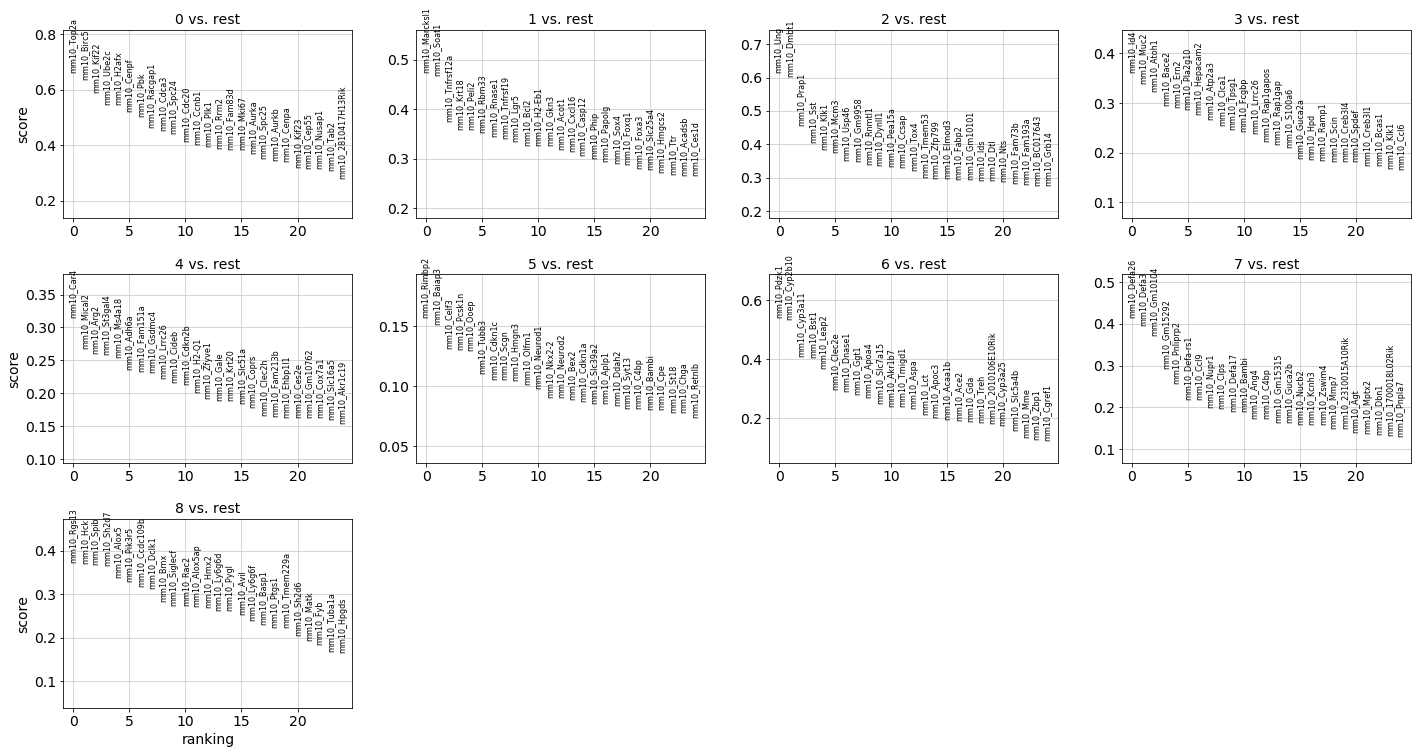

In [45]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon')

Many of the same genes were found in each of the three different tests but let's use the Mann-Whit results to create a list of marker genes.

Let's pull out the top 5 ranked genes for each cluster and call the top two "marker genes".

In [47]:
top_hits = pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)
top_hits

,0,1,2,3,4,5,6,7,8
0,mm10_Birc5,mm10_Gm15299,mm10_Dmbt1,mm10_Fcgbp,mm10_Smim24,mm10_Plb1,mm10_Fabp2,mm10_Defa17,mm10_Rgs13
1,mm10_H2afx,mm10_Gm15292,mm10_Retnlb,mm10_Guca2a,mm10_St3gal4,mm10_C4bp,mm10_Apoa1,mm10_Defa26,mm10_Alox5ap
2,mm10_Ube2c,mm10_Gm10104,mm10_Tmigd1,mm10_Muc2,mm10_2200002D01Rik,mm10_Celf5,mm10_Rbp2,mm10_Defa3,mm10_Ltc4s
